# Facial recognition with PCA and Eigenfaces - Lab

## Introduction
In this last lab of the section, we shall attempt to combine all the skills learnt around dimensionality reduction, running classification on reduced datasets and applying these in a image processing context. We shall look at a simple facial recognition experiment using PCA and Eigenfaces. As earlier, we shall try to run a classification task on the reduced dataset and check for the impact of PCA on classifier performance. Let's get on with it. 

## Objectives
You will be able to:
- Apply PCA to dataset containing images of human faces (or other visual objects)
- Calculate and visualize Eigenfaces from the given dataset
- Implement a machine learning pipeline in `scikit-learn` to perform preprocessing/classification and evaluation of facial a recognition task

## Facial Recognition

Face recognition is the challenge of classifying whose face is in an input image. This is different than face detection where the challenge is determining if there is a face in the input image. With face recognition, we need an existing database of faces. Given a new image of a face, we need to report the person’s name.

<img src="fr.jpg" width=400>

Formally, we can formulate face recognition as a classification task, where the inputs are images and the outputs are people’s names. We are going to perform a popular technique for face recognition called __eigenfaces__ which uses unsupervised dimensionality reduction with PCA.



__Eigenface__  is a name given to eigenvectors which are the components of the face itself. This technique has been used for face recognition where facial variations carry most importance. Although today there are better are more sophisticated approaches for performing this task e.g. deep networks, Eigenfaces still produce commendable results and with a little bit of tweaking, it can perform well where the focus is on data reduction and speed of execution. 

So let's get started , we shall first import required libraries below.

### Import Libraries
Import necessary libraries for above task 

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

## Olivetti Dataset

Image datasets can be huge in size. In order to create a facial dataset, a lot of preprocessing is generally required involving cropping, centering and color reductions etc to create data that contains JUST faces , which are comparable to each other. Sci-kit learn comes bundles with a couple of such datasets including `lfw` or "Labeled Faces in the Wild", containing images of 9 politicians, i.e. 9 classes. `Olivetti` faces dataset from AT&T contains a larger number of classes compared to lfw. So we let's run our experiment with this to really see the performance of classifier.


Before we start, lets analyze the Olivetti faces dataset to get a picture. The dataset consists of 400 images with greyscale 64×64 pixels . There are 10 images for each person, so there is 40 persons (target) which make it 40×100 equals 400 rows of data.  This means the dimensionality is huge with  64×64=4096 features. Lets import the dataset using scikit-learn built in function. The dataset is already normalized so you don't have to do preprocessing.

![](of.png)

Information on this dataset and how to import it can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html). 

### Import the Olivetti_faces dataset using scikit-learn and show the shape of dataset
We can `datasets` from `sklearn` to load the data. If the data isn't available on disk, scikit-learn will automatically download it. 

In [2]:
# Importing olivetti dataset
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

(400, 4096)

In [3]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

### Create X (features) and y (target) variabes from data and targets in the dataset. Check the shape. 
Create feature and target datasets from the `faces` dataset created above. 

In [4]:
# Create feature and target set
X = faces.data
y = faces.target
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


### Visualize first 20 images in the dataset 

Create subplots and run a loop to show first 20 images in the `faces` dataset. You can access an image by calling `faces.images[i]`, where `i` is the number of image we want to extract. 

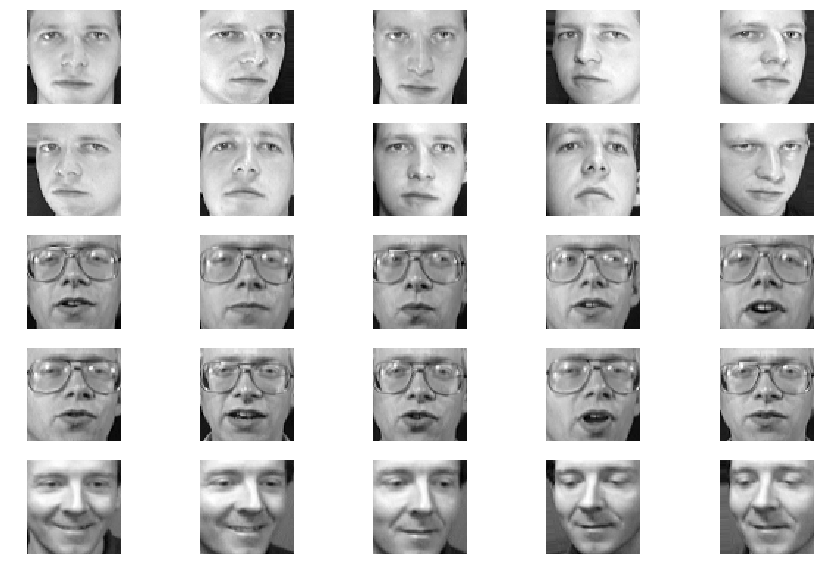

In [5]:
fig = plt.figure(figsize=(15, 10))

# plot several images
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.axis('off')
    
plt.show()

We see these faces have already been scaled to a common size. This is an important preprocessing piece for facial recognition, and is a process that can require a large collection of training data. This can be done in scikit-learn, but the challenge is gathering a sufficient amount of training data for the algorithm to work.

### Split the data into train and test sets using a 80/20 split. 
Split the features and  target variables for training and testing purpose and show the dimensions of both sets.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape

((320, 4096), (80, 4096))

We will now use scikit-learn’s PCA class to perform the dimensionality reduction. We have to select the number of components, i.e., the output dimensionality (the number of eigenvectors to project onto), that we want to reduce down to. We’ll use 150 components. Additionally, we’ll whiten our data, which is easy to do with a simple boolean flag! (Whitening just makes our resulting data have a unit variance, which has been shown to produce better results)

### Apply PCA to the training data with 150 components

4096 dimensions is a lot for any classifier. We can use PCA to reduce these features to a manageable size, while maintaining most of the information in the dataset.

In [7]:
pca = PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

### Compute the mean face

One interesting part of PCA is that it computes the “mean” face, which can be interesting to examine. This can be computed with `pca.mean_`. This face will show you the mean for each dimension for all the images in the dataset. So it effectively shows you one MEAN face reflecting all the faces in the dataset. 

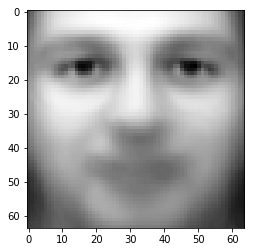

In [8]:
# Show the mean face 
plt.imshow(pca.mean_.reshape(faces.images[0].shape), cmap=plt.cm.gray)

### Visualize Principal Components for 25 Images - EigenFaces

The principal components measure deviations about this mean along orthogonal axes. Let's Visualize these principal components just like we visualized actual images above. These components can be accessed via `pca.components_[i]` where i is image you want to access. 

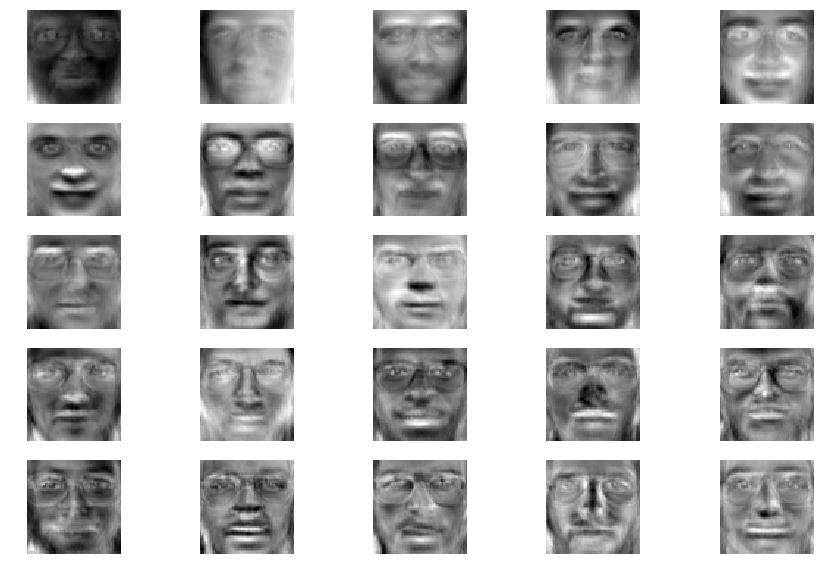

In [9]:
fig = plt.figure(figsize=(15, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape), cmap=plt.cm.gray)
    ax.axis('off')

These components (“eigenfaces”) are ordered by their importance from top-left to bottom-right. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training and test data onto the PCA.

### Transform train and test datasets using trained PCA instance

We can apply the transform to bring our images down to a 150-dimensional space. 

Check the shape of PCA components and transform test and train sets with PCA. Show the shape of resulting datasets.

In [10]:
# Transform train and test datasets using trained PCA algorithm
X_train_transform = pca.transform(X_train)
X_test_transform = pca.transform(X_test)

print(pca.components_.shape)
print(X_train_transform.shape, X_test_transform.shape)

(150, 4096)
(320, 150) (80, 150)


These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face.

### Run an SVM Classifier

After preprocessing our face data with PCA, we can run an SVM classifier to make predictions on the test set. For SVM, set C = 0.5 and gamma = 0.001. 

In [11]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_transform, y_train)

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Pick up 30 images from the test data and predict their labels. 

Finally, we can evaluate how well this classification did. First, we might plot a few of the test-cases with the labels learned from the training set.

- Show the image, predicted value and weather it was a correct prediction or not. 

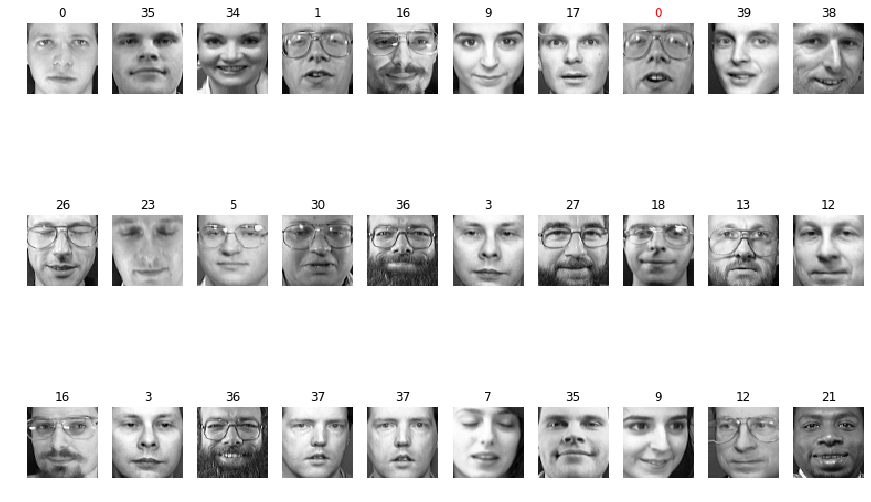

In [12]:
import numpy as np

preds = []
fig = plt.figure(figsize=(15, 10))

for i in range(30):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(X_test[i].reshape(faces.images[0].shape), cmap=plt.cm.gray)
    pred = clf.predict(X_test_transform[i, np.newaxis])[0]
    preds.append(pred)
    color = 'black' if pred == y_test[i] else 'red'
    ax.set_title(pred, color=color)
    ax.axis('off')

So out of all images, we see few wrong predictions, highlighted in red above. This doesn't sound so bad. IF you visually investigate this , you will realize that people predicted incorrectly are either not not looking straight at the camera , or smiling etc so their faces look quite different than other instances of same person. 

### Create a Classification Report

Predict the labels for complete test dataset and calculate the performance of classifier using `metrics.classification_report` to identify precision, recall, f1-score etc for each class in the dataset. Comment on the output. 

In [18]:
# Create a classification report
preds = clf.predict(X_test_transform)

print(classification_report(y_test, preds))



              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.75      0.86         4
           2       1.00      0.50      0.67         2
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         1
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         2
          18       1.00    

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Thats pretty good , we can identify the wrong predictions from this report and inspect the images independently to see why they were misclassified.  WE can visualize a confusion matrix to confirm this. 

### Create a confusion matrix from classification results

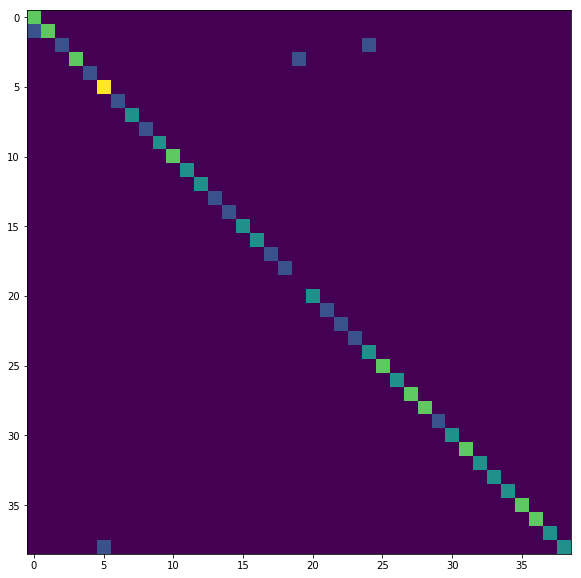

In [24]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix(y_test, preds))
plt.show()

Above confirms our understanding around mis-classifications. 

Scikit-learn's ability to chain together different algorithms to create machine learning pipelines is a handy way to create complex computational architectures with just a few lines of code. Let's create a simple pipeline using skill we have already seen to perform above experiment in a single go. 

### Create an `scikit-learn` Pipeline to chain together PCA and SVM 

In [30]:
# Chain PCA and SVM to run above experiment in a single execution. 
from sklearn.pipeline import Pipeline

clf = Pipeline([('pca', PCA(n_components=150, whiten=True)), 
                ('svm', svm.LinearSVC(C=1.0))])

clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(confusion_matrix(preds, y_test))
print(classification_report(y_test, preds))

[[3 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         1
          16   

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So here it is , our facial recognition system which performs quite well on this toy dataset that we saw. LAter on we shall look at more sophisticated approaches which might serve the same purpose. The focus here is on dimensionality reduction and developing an intuition around the idea that high dimensional datasets can be reduced to a large extent without too much compromise towards the predictive abilities of data. 

## Level Up - Optional 
- Use `lfw` dataset and run the above code again to understand the process better
- Create your own dataset! I

If you want to create your own face dataset, you’ll need several pictures of each person’s face (at different angles and lighting), along with the ground-truth labels. The wider variety of faces you use, the better the recognizer will do. The easiest way to create a dataset for face recognition is to create a folder for each person and put the face images in there. Make sure each are the same size and resize them so they aren’t large images! Remember that PCA will reduce the image’s dimensionality when we project onto that space anyways so using large, high-definition images won’t help and will slow down our algorithm. A good size is ~512×512 for each image. The images should all be the same size so you can store them in one numpy array with dimensions (num_examples, height, width) . (We’re assuming grayscale images). Then use the folder names to disambiguate classes. Using this approach, you can use your own images.

# Further Reading 
- [Maths behind computation of Eigenfaces](http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf) 
- [PCA, Eigenfaces and all that](http://bugra.github.io/work/notes/2013-07-27/PCA-EigenFace-And-All-That/)

## Summary

Great! This was your first real introduction to analyzing images. You'll see much more on this in future lessons and labs!